In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)

In [3]:
info_mag = epochs.copy().pick_types(meg='mag').info
info_grad = epochs.copy().pick_types(meg='grad').info

In [4]:
from copy import deepcopy
from deepmeg.utils import check_path
from deepmeg.preprocessing.transforms import zscore, one_hot_encoder
from typing import Callable, Iterable


class GradMagEpochsDataset(EpochsDataset):
    def __init__(
        self,
        epochs: str | os.PathLike | tuple[np.ndarray, np.ndarray] | tuple[np.ndarray, np.ndarray, Iterable] | mne.Epochs,
        transform: Callable[[torch.Tensor], torch.Tensor] = None, target_transform: Callable[[torch.Tensor], torch.Tensor]  = None,
        savepath: str | os.PathLike = './data'
    ):
        if isinstance(epochs, (str, os.PathLike)):
            epochs = mne.read_epochs(epochs)

        if isinstance(epochs, (mne.Epochs, mne.epochs.EpochsArray)):
            data_mag = epochs.copy().pick_types(meg='mag').get_data()
            X_mag = [torch.Tensor(sample) for sample in data_mag]
            data_grad = epochs.copy().pick_types(meg='grad').get_data()
            X_grad = [torch.Tensor(sample) for sample in data_grad]
            Y = one_hot_encoder(epochs.events[:, 2])
            Y = [torch.Tensor(event) for event in Y]
        elif isinstance(epochs, tuple):
            X_mag = [torch.Tensor(sample) for sample in epochs[0]]
            X_grad = [torch.Tensor(sample) for sample in epochs[1]]
            Y = [torch.Tensor(target) for target in epochs[2]]
        else:
            raise ValueError(f'Unsupported type for data samples: {type(epochs)}')

        self.n_samples = len(Y)
        self.savepath = savepath
        self.transform = transform
        self.target_transform = target_transform

        check_path(savepath)

        for i, (mag, grad, target) in enumerate(zip(X_mag, X_grad, Y)):
            torch.save(mag, os.path.join(self.savepath, f'sample_mag_{i}.pt'))
            torch.save(grad, os.path.join(self.savepath, f'sample_grad_{i}.pt'))
            torch.save(target, os.path.join(self.savepath, f'target_{i}.pt'))

    def __getitem__(self, idx):
        sample_mag_path = os.path.join(self.savepath, f'sample_mag_{idx}.pt')
        sample_grad_path = os.path.join(self.savepath, f'sample_grad_{idx}.pt')
        target_path = os.path.join(self.savepath, f'target_{idx}.pt')

        X_mag = torch.load(sample_mag_path)
        X_grad = torch.load(sample_grad_path)
        Y = torch.load(target_path)

        if self.transform:
            X_mag = self.transform(X_mag)
            X_grad = self.transform(X_grad)

        if self.target_transform:
            Y = self.target_transform(Y)

        return (X_mag, X_grad), Y

In [5]:
dataset = GradMagEpochsDataset(epochs, savepath='../datasets/gradmag', transform = zscore)
dataset.save('../data/gradmag.pt')

In [5]:
dataset = EpochsDataset.load('../data/gradmag.pt')

In [7]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [34]:
from deepmeg.models.interpretable import LFCNN
from deepmeg.models import BaseModel
from deepmeg.utils.viz import plot_metrics

class GMLFCNN(BaseModel):

    def __init__(
        self,
        n_mag: int,
        n_grad: int,
        n_latent_mag: int,
        n_latent_grad: int,
        n_times: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_mag_layer = nn.Conv1d(n_mag, n_latent_mag, kernel_size=1, bias=True)
        self.unmixing_grad_layer = nn.Conv1d(n_grad, n_latent_grad, kernel_size=1, bias=True)
        self.temp_conv_mag = nn.Conv1d(n_latent_mag, n_latent_mag, kernel_size=filter_size, bias=True, groups=n_latent_mag, padding='same')
        self.temp_conv_grad = nn.Conv1d(n_latent_grad, n_latent_grad, kernel_size=filter_size, bias=True, groups=n_latent_grad, padding='same')
        final_out_mag_features = (n_times//pool_factor)*n_latent_mag if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent_mag
        final_out_grad_features = (n_times//pool_factor)*n_latent_grad if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent_grad
        self.fc_layer = nn.Linear(final_out_mag_features + final_out_grad_features, n_outputs)
        # self.fc_layer = nn.Linear(final_out_grad_features, n_outputs)
        # self.fc_layer = nn.Linear(final_out_mag_features, n_outputs)


    def forward(self, x: tuple[torch.Tensor]):
        mag, grad = x
        mag = self.unmixing_mag_layer(mag)
        grad = self.unmixing_grad_layer(grad)
        mag = self.temp_conv_mag(mag)
        grad = self.temp_conv_grad(grad)
        mag = mag[:, :, ::self.pool_factor].contiguous()
        grad = grad[:, :, ::self.pool_factor].contiguous()
        x = torch.cat((mag, grad), dim=1)
        # x = grad
        # x = mag
        x = torch.flatten(x, 1)
        return self.fc_layer(x)


from deepmeg.experimental.layers import LW

class GMLFCNNW(BaseModel):
    def __init__(
        self,
        n_mag: int,
        n_grad: int,
        n_latent_mag: int,
        n_latent_grad: int,
        n_times: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.n_latent_mag = n_latent_mag
        self.n_latent_grad = n_latent_grad
        self.pool_factor = pool_factor
        self.unmixing_mag_layer = nn.Conv1d(n_mag, n_latent_mag, kernel_size=1, bias=True)
        self.unmixing_grad_layer = nn.Conv1d(n_grad, n_latent_grad, kernel_size=1, bias=True)
        self.temp_conv_mag = nn.Conv1d(n_latent_mag, n_latent_mag, kernel_size=filter_size, bias=True, groups=n_latent_mag, padding='same')
        self.temp_conv_grad = nn.Conv1d(n_latent_grad, n_latent_grad, kernel_size=filter_size, bias=True, groups=n_latent_grad, padding='same')
        self.temp_sel_mag = nn.ModuleList([LW(n_times) for _ in range(self.n_latent_mag)])
        self.temp_sel_grad = nn.ModuleList([LW(n_times) for _ in range(self.n_latent_grad)])
        final_out_mag_features = (n_times//pool_factor)*n_latent_mag if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent_mag
        final_out_grad_features = (n_times//pool_factor)*n_latent_grad if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent_grad
        self.fc_layer = nn.Linear(final_out_mag_features + final_out_grad_features, n_outputs)

    def forward(self, x: tuple[torch.Tensor]):
        mag, grad = x
        mag = self.unmixing_mag_layer(mag)
        grad = self.unmixing_grad_layer(grad)
        mag = self.temp_conv_mag(mag)
        grad = self.temp_conv_grad(grad)
        mag = torch.stack([lw(mag[:, branch_n, :]) for lw, branch_n in zip(self.temp_sel_mag, range(self.n_latent_mag))], -2)
        grad = torch.stack([lw(grad[:, branch_n, :]) for lw, branch_n in zip(self.temp_sel_grad, range(self.n_latent_grad))], -2)
        mag = mag[:, :, ::self.pool_factor].contiguous()
        grad = grad[:, :, ::self.pool_factor].contiguous()
        x = torch.cat((mag, grad), dim=1)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

In [35]:
(mag, grad), target = train[0]
model = GMLFCNNW(
    n_mag = mag.shape[0],
    n_grad = grad.shape[0],
    n_latent_mag = 4,
    n_latent_grad = 8,
    n_times = mag.shape[1],
    filter_size = 50,
    pool_factor = 10,
    n_outputs = target.shape[0]
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_mag_layer.weight', 'temp_conv_mag.weight',
                'unmixing_grad_layer.weight', 'temp_conv_grad.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [36]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7454   |    binary_accuracy_train:  0.5176   |    loss_val:  0.7420   |    binary_accuracy_val:  0.6058
Epoch 1:  loss_train:  0.7408   |    binary_accuracy_train:  0.6557   |    loss_val:  0.7370   |    binary_accuracy_val:  0.7679
Epoch 2:  loss_train:  0.7355   |    binary_accuracy_train:  0.8481   |    loss_val:  0.7310   |    binary_accuracy_val:  0.8750
Epoch 3:  loss_train:  0.7289   |    binary_accuracy_train:  0.8750   |    loss_val:  0.7235   |    binary_accuracy_val:  0.8750
Epoch 4:  loss_train:  0.7208   |    binary_accuracy_train:  0.8750   |    loss_val:  0.7142   |    binary_accuracy_val:  0.8750
Epoch 5:  loss_train:  0.7106   |    binary_accuracy_train:  0.8750   |    loss_val:  0.7027   |    binary_accuracy_val:  0.8750
Epoch 6:  loss_train:  0.6982   |    binary_accuracy_train:  0.8750   |    loss_val:  0.6888   |    binary_accuracy_val:  0.8750
Epoch 7:  loss_train:  0.6831   |    binary_accuracy_train:  0.8750   |    loss_val:  0.6721   | 

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

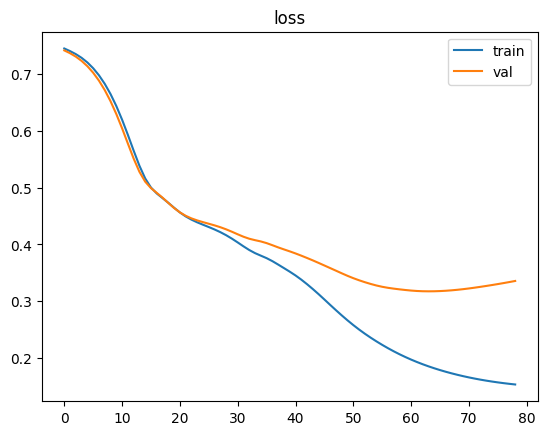

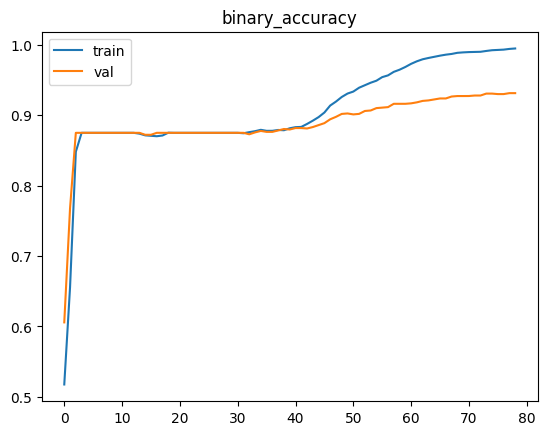

In [37]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [38]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.21204770695079456
train_binary_accuracy: 0.9688592607324774
loss: 0.2856989828023044
binary_accuracy: 0.9354707815430381
